# Double Layer Network Example

Note: This notebook is desinged to run with Python3 and CPU (no GPU) runtime.

![Python 3 and CPU runtime](https://raw.githubusercontent.com/enakai00/colab_tfbook/master/docs/imgs/runtime_cpu.png)

In [1]:
%%bash
tf_version='2.0.0rc0'
if pip freeze | grep -q "^tensorflow==${tf_version}$"; then
  echo "tensorflow==${tf_version} is already installed. No actions are required."
else
  echo "Installing tensorflow==${tf_version}. Don't forget to restart the runtime."
  pip install tensorflow==${tf_version}
fi

tensorflow==2.0.0rc0 is already installed. No actions are required.


####[DNE-01]
Import modules and set a random seed.

In [0]:
import numpy as np
from numpy.random import multivariate_normal, permutation
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, initializers

np.random.seed(20160615)
tf.random.set_seed(20190819)
#tf.random.set_seed(20190823) # local minimum

####[DNE-02]
Generate a training dateset.

In [0]:
def generate_datablock(n, mu, var, t):
    data = multivariate_normal(mu, np.eye(2)*var, n)
    df = DataFrame(data, columns=['x1', 'x2'])
    df['t'] = t
    return df

df0 = generate_datablock(30, [-7,-7], 18, 1)
df1 = generate_datablock(30, [-7,7], 18, 0)
df2 = generate_datablock(30, [7,-7], 18, 0)
df3 = generate_datablock(30, [7,7], 18, 1)

df = pd.concat([df0, df1, df2, df3], ignore_index=True)
train_set = df.reindex(permutation(df.index)).reset_index(drop=True)

####[DNE-03]
Store the coordinates $(x_1,x_2)$ and label values $t$ into NumPy arrays.

In [0]:
train_x = train_set[['x1', 'x2']].values
train_t = train_set['t'].values

####[DNE-04]
Define a model for the binary classification using two hidden layers.

Weights in the hidden layers are initialized with random values.

In [5]:
model = models.Sequential()
model.add(layers.Dense(2, activation='tanh',input_shape=(2,),
                       kernel_initializer=initializers.TruncatedNormal(),
                       name='hidden1'))
model.add(layers.Dense(2, activation='tanh',
                       kernel_initializer=initializers.TruncatedNormal(),
                       name='hidden2'))
model.add(layers.Dense(1, activation='sigmoid',
                       name='output'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 2)                 6         
_________________________________________________________________
hidden2 (Dense)              (None, 2)                 6         
_________________________________________________________________
output (Dense)               (None, 1)                 3         
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________


####[DNE-05]
Compile the model using the Adam optimizer, and Cross entroy as a loss function.

In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

####[DNE-06]
Train the model.

In [7]:
history = model.fit(train_x, train_t,
                    batch_size=len(train_set), epochs=2000, verbose=0)

W0826 10:23:49.022317 140052032927616 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/nn_impl.py:183: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


####[DNE-07]
Plot charts for the accuracy and loss values.

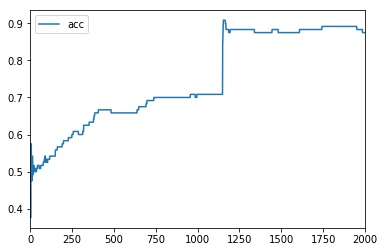

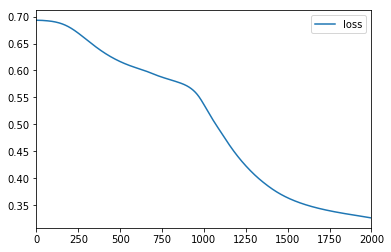

In [8]:
DataFrame({'acc': history.history['acc']}).plot(grid=False)
DataFrame({'loss': history.history['loss']}).plot(grid=False)

####[DNE-08]
Plot charts for the final result.

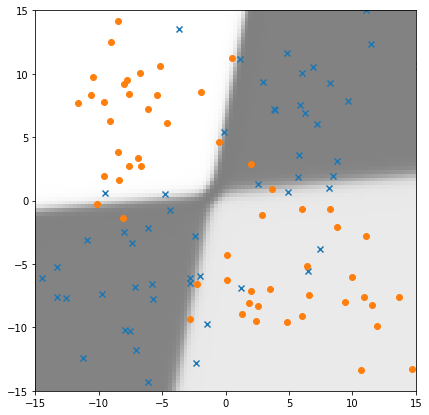

In [9]:
train_set1 = train_set[train_set['t']==1]
train_set2 = train_set[train_set['t']==0]

fig = plt.figure(figsize=(7, 7))
subplot = fig.add_subplot(1, 1, 1)
subplot.set_ylim([-15, 15])
subplot.set_xlim([-15, 15])
subplot.scatter(train_set1.x1, train_set1.x2, marker='x')
subplot.scatter(train_set2.x1, train_set2.x2, marker='o')

locations = [[x1, x2] for x2 in np.linspace(-15, 15, 100) 
                      for x1 in np.linspace(-15, 15, 100)]
p_vals = model.predict(np.array(locations)).reshape((100, 100))
subplot.imshow(p_vals, origin='lower', extent=(-15, 15, -15, 15),
               cmap=plt.cm.gray_r, alpha=0.5)